# Hypoxia reperfusion simulation

In [1]:
using ProgressLogging
using OrdinaryDiffEq
using ModelingToolkit
using DiffEqCallbacks
using ECMEDox
using ECMEDox: second, Hz, μM, nM, build_stim_callbacks
using Plots
using DisplayAs: PNG
Plots.default(lw=1.5)

In [2]:
tend = 100.0second
bcl = 1.0second
@named sys = build_model(; bcl, tend)
u0 = build_u0(sys)
sts = unknowns(sys)
alg = KenCarp47()
@unpack O2 = sys
prob = ODEProblem(sys, [u0;  O2 => 6nM], tend)

reoxygen! = (integrator) -> begin
    integrator.ps[sys.O2] = 6μM
    set_proposed_dt!(integrator, 1e-6)
end

cbs = PresetTimeCallback(50.0second, reoxygen!)

┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/variable.jl:587
┌ Warning: Did not converge after `maxiters = 0` substitutions. Either there is a cycle in the rules or `maxiters` needs to be higher.
└ @ Symbolics ~/.julia/packages/Symbolics/sc64L/src/v

SciMLBase.DiscreteCallback{DiffEqCallbacks.PresetTimeFunction{Vector{Float64}, typeof(SciMLBase.INITIALIZE_DEFAULT), Main.var"##230".var"#1#2"}, Main.var"##230".var"#1#2", DiffEqCallbacks.PresetTimeFunction{Vector{Float64}, typeof(SciMLBase.INITIALIZE_DEFAULT), Main.var"##230".var"#1#2"}, typeof(SciMLBase.FINALIZE_DEFAULT), Nothing}(DiffEqCallbacks.PresetTimeFunction{Vector{Float64}, typeof(SciMLBase.INITIALIZE_DEFAULT), Main.var"##230".var"#1#2"}([50000.0], true, SciMLBase.INITIALIZE_DEFAULT, Main.var"##230".var"#1#2"()), Main.var"##230".var"#1#2"(), DiffEqCallbacks.PresetTimeFunction{Vector{Float64}, typeof(SciMLBase.INITIALIZE_DEFAULT), Main.var"##230".var"#1#2"}([50000.0], true, SciMLBase.INITIALIZE_DEFAULT, Main.var"##230".var"#1#2"()), SciMLBase.FINALIZE_DEFAULT, Bool[1, 1], nothing)

In [3]:
@time sol = solve(prob, alg; reltol=1e-6, abstol=1e-6, progress=true, dt=1e-6, callback=cbs)

  6.389516 seconds (21.16 M allocations: 1.020 GiB, 3.99% gc time, 82.68% compilation time)


retcode: Success
Interpolation: 3rd order Hermite
t: 10983-element Vector{Float64}:
      0.0
      1.0e-6
      1.1e-5
      0.00011099999999999999
      0.0011109999999999998
      0.0098657916786707
      0.02266582512295119
      0.04037540120694326
      0.06531031960839598
      0.10106523201078316
      ⋮
  99572.6383877471
  99620.61361158677
  99671.83555021304
  99728.58061877913
  99789.68385524656
  99853.4504871416
  99923.6668897242
 100000.0
 100000.0
u: 10983-element Vector{Vector{Float64}}:
 [0.3553843722148506, 162.59478245522047, 507.9034833706153, 14.892129267047379, 48.65695610700525, 0.9114480160471111, 0.19409331392839435, 1205.8091362833657, 1209.9687795381885, 144753.168650273  …  165.09011792191754, 91.87929617274456, 91.91725390039272, 1842.3823360869799, 131.3763898444155, 0.024427237952508167, 16.995660402659126, 1.9070224132868452, 0.0006449826277658302, 0.000865771566630073]
 [0.3553843443914563, 162.59480862690788, 507.90348338598517, 14.892129266274098,

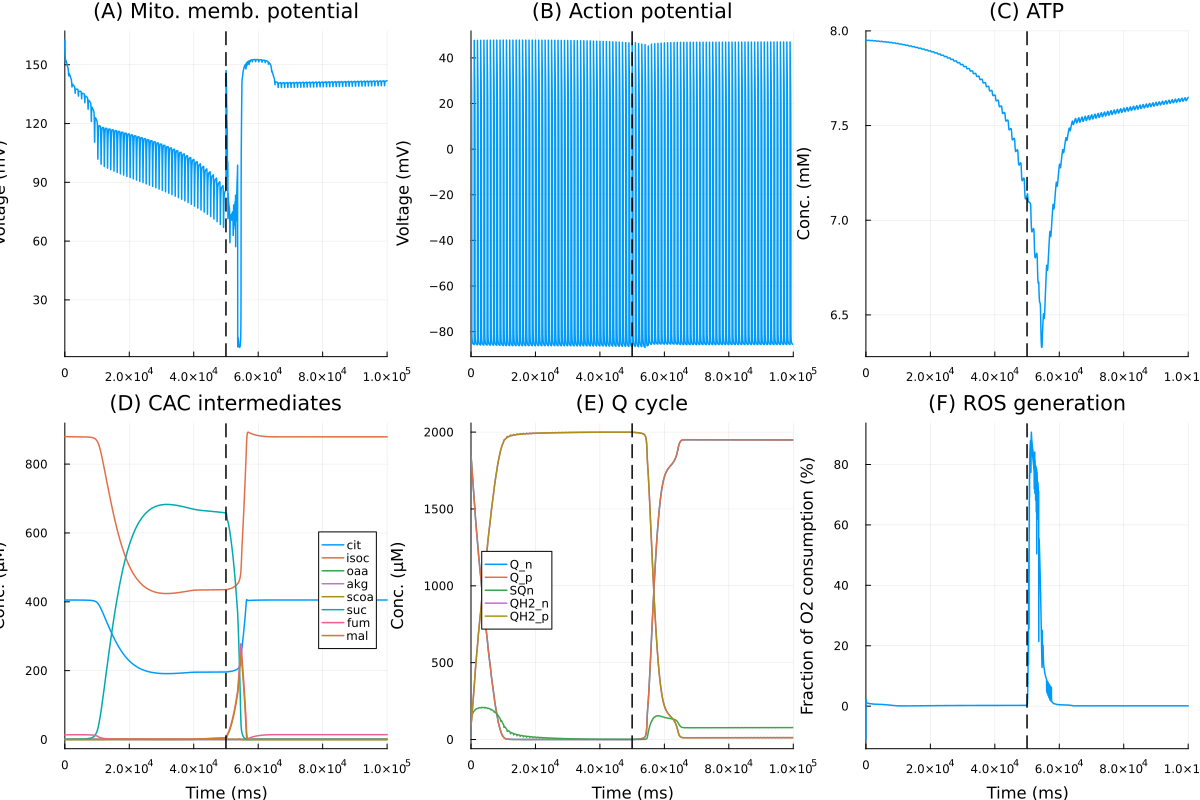

In [4]:
@unpack vm, dpsi, atp_i, adp_i = sys
pl_mmp = plot(sol, idxs=dpsi, lab=false, title="(A) Mito. memb. potential", xlabel="", ylabel="Voltage (mV)")
pl_mmp = vline!(pl_mmp, [50.0second], lines=(:dash, :black), lab=false)
pl_vm = plot(sol, idxs=vm, lab=false, title="(B) Action potential", xlabel="", ylabel="Voltage (mV)")
pl_vm = vline!(pl_vm, [50.0second], lines=(:dash, :black), lab=false)
pl_atp = plot(sol, idxs=atp_i/1000, lab=false, title="(C) ATP", xlabel="", ylabel="Conc. (mM)")
pl_atp = vline!(pl_atp, [50.0second], lines=(:dash, :black), lab=false)
@unpack cit, isoc, oaa, akg, scoa, suc, fum, mal = sys
pl_cac = plot(sol, idxs=[cit, isoc, oaa, akg, scoa, suc, fum, mal], legend=:right, title="(D) CAC intermediates", xlabel="Time (ms)", ylabel="Conc. (μM)")
pl_cac = vline!(pl_cac, [50.0second], lines=(:dash, :black), lab=false)
@unpack Q_n, SQn, QH2_n, QH2_p, Q_p, fes_ox, fes_rd, cytc_ox, cytc_rd = sys
pl_q = plot(sol, idxs=[Q_n, Q_p, SQn, QH2_n, QH2_p], title="(E) Q cycle", legend=:left, xlabel="Time (ms)", ylabel="Conc. (μM)")
pl_q = vline!(pl_q, [50.0second], lines=(:dash, :black), lab=false)
pl_ros = plot(sol, idxs=100 * sys.vROS / (sys.vO2 + sys.vROS), title="(F) ROS generation", lab=false, xlabel="Time (ms)", ylabel="Fraction of O2 consumption (%)")
pl_ros = vline!(pl_ros, [50.0second], lines=(:dash, :black), lab=false)
plot(pl_mmp, pl_vm, pl_atp, pl_cac, pl_q, pl_ros, size=(1200, 800)) |> PNG

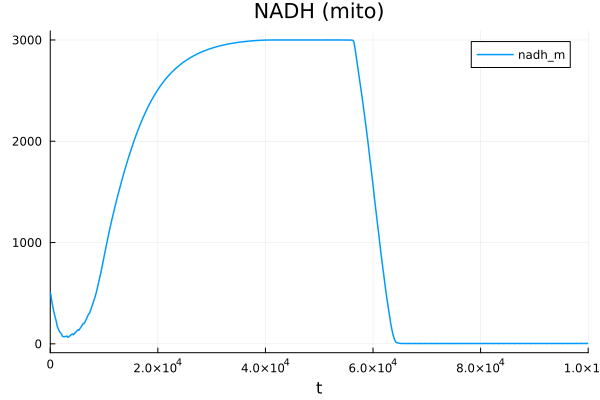

In [5]:
plot(sol, idxs=sys.nadh_m, title="NADH (mito)")

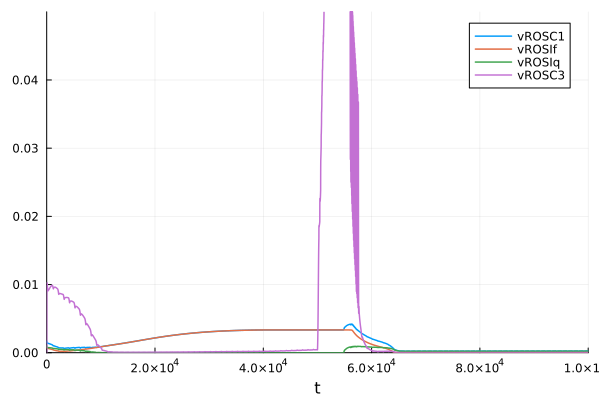

In [6]:
plot(sol, idxs=[sys.vROSC1, sys.vROSIf, sys.vROSIq, sys.vROSC3], ylims=(0.0, 0.05))

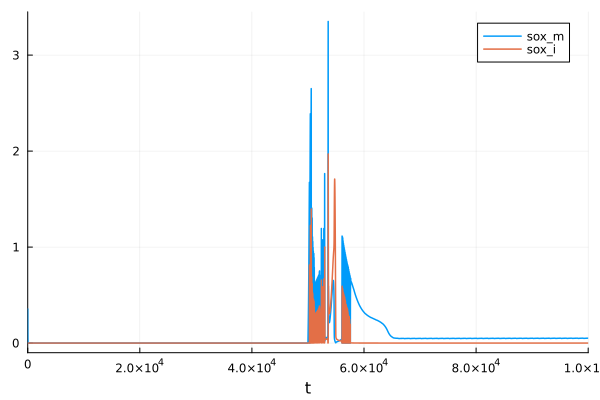

In [7]:
plot(sol, idxs=[sys.sox_m, sys.sox_i])

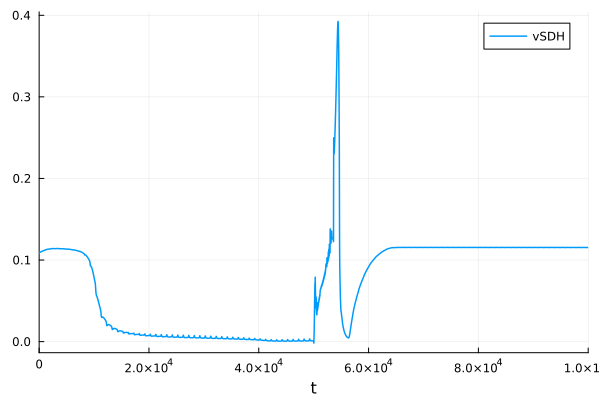

In [8]:
plot(sol, idxs=[sys.vSDH])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*